In [41]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F

# R2 score
from sklearn.metrics import r2_score

# Analyse Outputs
import shap

# To split the data
from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter

np.set_printoptions(precision=2, suppress=True)
torch.set_printoptions(precision=2, sci_mode=False)

In [5]:
# It is important that your model and all data are on the same device.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Check that MPS is available - Added for MacOS
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

device

device(type='mps')

In [51]:
def get_data1(test_size=0.2, random_seed=42):
    '''
    returns:
    - train_data_input: Tensor[N_train_samples, C, F]
    - train_data_label: Tensor[N_train_samples, C, P]
    - test_data_input:  Tensor[N_test_samples,  C, F]
    - test_date_label:  Tensor[N_test_samples,  C, P]

    where 
     - N_train_samples = number of train/test samples
     - C = number of channels (here 1)
     - F = number of features
     - P = number of predicted features
    '''
    
    data    = pd.read_csv("../../ICPSR_IHDS-1/Simon_Personal_Aggregates/basic_plus1_features.csv")
    
    # Step 1: Replace ' ' and '' with -1
    data = data.replace([' ', ''], -1)
    # Step 2: Try to convert everything to numeric, forcing errors to NaN
    data = data.apply(pd.to_numeric, errors='coerce')
    # Step 3: Replace NaNs with -1
    data = data.fillna(-1)

    
    # 2. Drop rows with negative household_income
    data = data[ data['household_income'] >= 0 ]

    data_label = data['household_income']
    data_input = data.drop(['household_income', 'household_id', 'distid', 'distname'], axis=1)

    # Split data to get test and train set -> For generalization error prediction
    X_train, X_test, y_train, y_test = train_test_split(
        data_input, data_label,
        test_size=test_size,
        random_state=random_seed
    )
    
    # Convert to numpy arrays
    X_train_np = X_train.to_numpy().astype(np.long)
    X_test_np = X_test.to_numpy().astype(np.long)

    y_train_np = y_train.to_numpy().astype(np.float32)
    y_test_np = y_test.to_numpy().astype(np.float32)
    
    train_y_to = torch.tensor(y_train_np, dtype=torch.float32)
    test_y_to = torch.tensor(y_test_np, dtype=torch.float32)

    # Also prepare input_dict (for models expecting dict inputs)
    X_dict_train = {col: torch.tensor(X_train[col].values, dtype=torch.long) for col in X_train.columns}
    X_dict_test  = {col: torch.tensor(X_test[col].values, dtype=torch.long)  for col in X_test.columns}

    return X_dict_train, train_y_to, X_dict_test, test_y_to
    
    # return datainp_to, datalab_to, input_dict
    
    

X_train, y_train, X_test, y_test = get_data1()
# get_data1()

/var/folders/nk/x80qqs8j2d3d7n0h5xw1d8c00000gn/T/ipykernel_79517/4261298921.py:16: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data    = pd.read_csv("../../ICPSR_IHDS-1/Simon_Personal_Aggregates/basic_plus1_features.csv")


In [60]:
# Mapping of feature names to cardinalities
more_column_cardinalities = {
    'stateid': 33,
    'highest_adult_ed': 16,
    'highest_male_ed': 16,
    'highest_female_ed': 16,
    'literate_ad': 2,
    'Nhh_salaried': 7,
    'Nhh_ag_wage': 10,
    'Nhh_nonag_wage': 9,
    'Nhh_fam_bus': 8,
    'hhassets': 31,
    'owns_car': 2,
    'owns_computer': 2,
    'npersons': 38,
    'nchild': 18,
    'nadults': 19,
    'urban': 2,
    'metro': 7,
    'caste_rel': 8
}

# Heuristic for embedding dimension: half of unique categories, capped at 50
def get_embedding_dim(n_unique):
    return min(50, max(1, n_unique // 2))

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Embeddings for all categorical features
        self.embeddings = nn.ModuleDict({
            name: nn.Embedding(n_unique, get_embedding_dim(n_unique))
            for name, n_unique in more_column_cardinalities.items()
        })
        # Sum of all embedding dims
        total_embed_dim = sum(
            get_embedding_dim(n_unique)
            for n_unique in more_column_cardinalities.values()
        )
        # LSTM to process embeddings as a single time-step sequence
        self.lstm_hidden = 64
        self.lstm = nn.LSTM(
            input_size=total_embed_dim,
            hidden_size=self.lstm_hidden,
            num_layers=1,
            batch_first=True
        )
        # Fully connected head after LSTM
        self.fc = nn.Sequential(
            nn.Linear(self.lstm_hidden, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x_dict):
        # Embed each categorical feature
        embeds = [
            self.embeddings[name](x_dict[name])
            for name in more_column_cardinalities.keys()
        ]
        # Concatenate embeddings into a single vector
        x_embed = torch.cat(embeds, dim=1)  # [batch, total_embed_dim]
        # Treat as one time-step sequence
        x_seq = x_embed.unsqueeze(1)       # [batch, 1, total_embed_dim]
        # Initialize LSTM hidden and cell states
        h0 = torch.zeros(1, x_seq.size(0), self.lstm_hidden, device=x_seq.device)
        c0 = torch.zeros(1, x_seq.size(0), self.lstm_hidden, device=x_seq.device)
        # LSTM forward
        lstm_out, (hn, cn) = self.lstm(x_seq, (h0, c0))
        # Take final hidden state
        x_lstm = hn[-1]                    # [batch, lstm_hidden]
        # Pass through FC head
        output = self.fc(x_lstm)           # [batch, 1]
        return output.squeeze(1)           # [batch]


In [36]:
%load_ext tensorboard
# %reload_ext tensorboard
# !rm -rf ./runs/
%tensorboard --logdir=runs --port=6006

'''
to kill process
pgrep -f tensorboard
kill -9 pid1 pid2 ...

Income
• Mean: 59659.41
• Minimum: -108327.80
• Maximum: 6520261.00
• Standard Deviation: 94614.89
'''

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'\nto kill process\npgrep -f tensorboard\nkill -9 pid1 pid2 ...\n\nIncome\n• Mean: 59659.41\n• Minimum: -108327.80\n• Maximum: 6520261.00\n• Standard Deviation: 94614.89\n'

In [70]:
def train_model(input_dict_train, y_train, input_dict_test, y_test, n_epochs=30):
    writer = SummaryWriter()
    
    # --- 1. Initialize model ---
    model = Model()
    model.train()
    model.to(device)

    # --- 2. Set up training elements ---
    criterion = torch.nn.MSELoss()  # For regression
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    
    batch_size = 64 # Small for CPU ussage and faster convergence
    # batch_size = 100000 # Large for GPU ussage

    # --- 3. Prepare training Dataset and DataLoader ---
    input_features_train = torch.cat(
        [input_dict_train[key].unsqueeze(1) for key in input_dict_train.keys()], dim=1
    )
    dataset_train = TensorDataset(input_features_train, y_train)
    train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

    # --- 4. Prepare test data ---
    input_features_test = torch.cat(
        [input_dict_test[key].unsqueeze(1) for key in input_dict_test.keys()], dim=1
    )
    dataset_test = TensorDataset(input_features_test, y_test)
    test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    # --- 5. Training loop ---
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        
        for batch_inputs, batch_targets in tqdm(train_loader, desc=f"Training Epoch {epoch}", leave=False):
            # Split batch back into dict
            batch_input_dict = {}
            idx = 0
            for key in input_dict_train.keys():
                batch_input_dict[key] = batch_inputs[:, idx].to(device).long()
                idx += 1

            batch_targets = batch_targets.to(device)

            optimizer.zero_grad()
            outputs = model(batch_input_dict)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        scheduler.step()
        epoch_loss = epoch_loss / len(train_loader)

        # --- Evaluate on test set ---
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch_inputs, batch_targets in tqdm(test_loader, desc=f"Testing model in Epoch {epoch}", leave=False):
                batch_input_dict = {}
                idx = 0
                for key in input_dict_test.keys():
                    batch_input_dict[key] = batch_inputs[:, idx].to(device).long()
                    idx += 1

                batch_targets = batch_targets.to(device)
                outputs = model(batch_input_dict)
                loss = criterion(outputs, batch_targets)
                test_loss += loss.item()

        test_loss = test_loss / len(test_loader)

        # --- Print training and test loss ---
        print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {epoch_loss:.4f} - Test Loss: {test_loss:.4f}')
        
        # Optional: log to tensorboard
        writer.add_scalar("Loss/train", epoch_loss, epoch)
        writer.add_scalar("Loss/test", test_loss, epoch)

        # Save model every 10 epochs
        if (epoch % 10 == 9):
            print("Saving current state of the model")
            torch.save(model.state_dict(), 'NN_models/model_state.pt')

    writer.close()
    return model

def load_model(PATH="NN_models/model_state_nn2.pt"):
    model = Model()

    model.load_state_dict(torch.load(PATH))
    model.eval()
    model.to(device)
    return model

# Either train or load model that is already trained
trained_model = train_model(X_train, y_train, X_test, y_test)
# path = "NN_models/model_state_3_5_25.pt"
# trained_model = load_model(PATH=path)

Epoch 1/30 - Train Loss: 8433831356.8872 - Test Loss: 4025457444.7132


Epoch 2/30 - Train Loss: 5715542634.4591 - Test Loss: 3824138482.1085


Epoch 3/30 - Train Loss: 5545556926.3813 - Test Loss: 3732551748.9612


Epoch 4/30 - Train Loss: 5495095391.0039 - Test Loss: 3661060188.2791


Epoch 5/30 - Train Loss: 5482254777.7121 - Test Loss: 3703472423.6899


Epoch 6/30 - Train Loss: 5449062613.9144 - Test Loss: 3754093115.5349


Epoch 7/30 - Train Loss: 5477835368.5914 - Test Loss: 3672901101.1473


Epoch 8/30 - Train Loss: 5436076222.2568 - Test Loss: 3787425130.6667


Epoch 9/30 - Train Loss: 5474818325.4163 - Test Loss: 3683437143.8140


Epoch 10/30 - Train Loss: 5470312537.0272 - Test Loss: 3629431688.4341
Saving current state of the model


Epoch 11/30 - Train Loss: 5440823191.9066 - Test Loss: 3655681750.3256


Epoch 12/30 - Train Loss: 5355526124.2023 - Test Loss: 3664612356.4651


Epoch 13/30 - Train Loss: 5341068871.5953 - Test Loss: 3632411595.9070


Epoch 14/30 - Train Loss: 5308466587.2685 - Test Loss: 3626987583.5039


Epoch 15/30 - Train Loss: 5328037762.6148 - Test Loss: 3597104169.6744


Epoch 16/30 - Train Loss: 5263904847.5642 - Test Loss: 3622260602.5426


Epoch 17/30 - Train Loss: 5338220164.9805 - Test Loss: 3617497691.7829


Epoch 18/30 - Train Loss: 5303891093.5409 - Test Loss: 3671029650.8527


Epoch 19/30 - Train Loss: 5281474987.3307 - Test Loss: 3726096555.6589


Epoch 20/30 - Train Loss: 5299510464.8716 - Test Loss: 3628230050.7287
Saving current state of the model


Epoch 21/30 - Train Loss: 5212361209.5253 - Test Loss: 3666228825.3023


Epoch 22/30 - Train Loss: 5214318995.2996 - Test Loss: 3652726946.7287


Epoch 23/30 - Train Loss: 5214306423.6576 - Test Loss: 3677289421.3953


Epoch 24/30 - Train Loss: 5175904465.3074 - Test Loss: 3754652230.4496


Epoch 25/30 - Train Loss: 5158480845.6965 - Test Loss: 3735062672.8682


Epoch 26/30 - Train Loss: 5133137529.8988 - Test Loss: 3735525883.0388


Epoch 27/30 - Train Loss: 5104617530.8949 - Test Loss: 3848973649.3643


Epoch 28/30 - Train Loss: 5127615444.9183 - Test Loss: 3724795732.3411


Epoch 29/30 - Train Loss: 5113529768.8405 - Test Loss: 3838552663.8140


Epoch 30/30 - Train Loss: 5127220977.5564 - Test Loss: 3770597568.4961
Saving current state of the model


Metric             Loss (Rupee)      Conversion Rate      Loss (CHF)
-----------------------------------------------------------------
L1 Loss MAE          29269.8184               0.0098        286.8442
MSE Loss        3782919680.0000               0.0098   37072612.0000
R^2 Score                0.3367


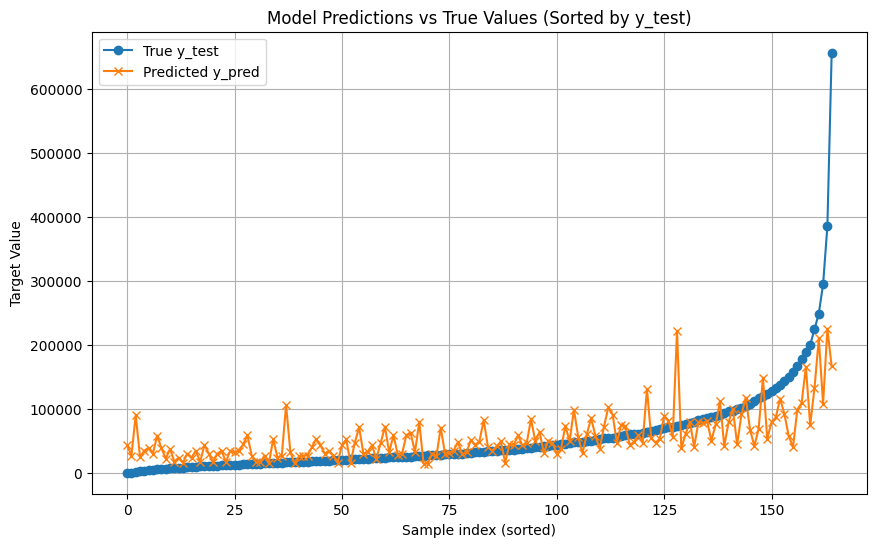

In [71]:
def test_model(X_test, y_test):
    model = trained_model
    
    # Move data to device
    X_test_device = { key: X_test[key].to(device) for key in X_test }
    y_test_device = y_test.to(device)

    # Forward pass
    with torch.no_grad():
        y_pred = model(X_test_device).squeeze()

    y_test_flat = y_test_device.clone().squeeze()

    # Compute losses
    l1loss  = torch.nn.L1Loss()
    mseloss = torch.nn.MSELoss()

    l1  = l1loss(y_pred, y_test_flat)
    mse = mseloss(y_pred, y_test_flat)

    # Compute R^2 (on CPU NumPy)
    y_true_np = y_test_flat.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()
    r2 = r2_score(y_true_np, y_pred_np)
    
    rate = 0.0098
    
    # Print metrics
    print(f"{'Metric':<15} {'Loss (Rupee)':>15} {'Conversion Rate':>20} {'Loss (CHF)':>15}")
    print(f"{'-'*65}")
    print(f"{'L1 Loss MAE':<15} {l1:>15.4f} {'0.0098':>20} {(rate * l1):>15.4f}")
    print(f"{'MSE Loss':<15} {mse:>15.4f} {'0.0098':>20} {(rate * mse):>15.4f}")
    print(f"{'R^2 Score':<15} {r2:>15.4f}")

    sorted_indices = torch.argsort(y_test)
    y_test_sorted = y_test[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]

    step = 50

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_sorted.cpu().numpy()[::step], label='True y_test', marker='o')
    plt.plot(y_pred_sorted.cpu().numpy()[::step], label='Predicted y_pred', marker='x')
    plt.title('Model Predictions vs True Values (Sorted by y_test)')
    plt.xlabel('Sample index (sorted)')
    plt.ylabel('Target Value')
    plt.legend()
    plt.grid(True)
    plt.show()

test_model(X_test, y_test)

  0%|          | 0/1643 [00:00<?, ?it/s]

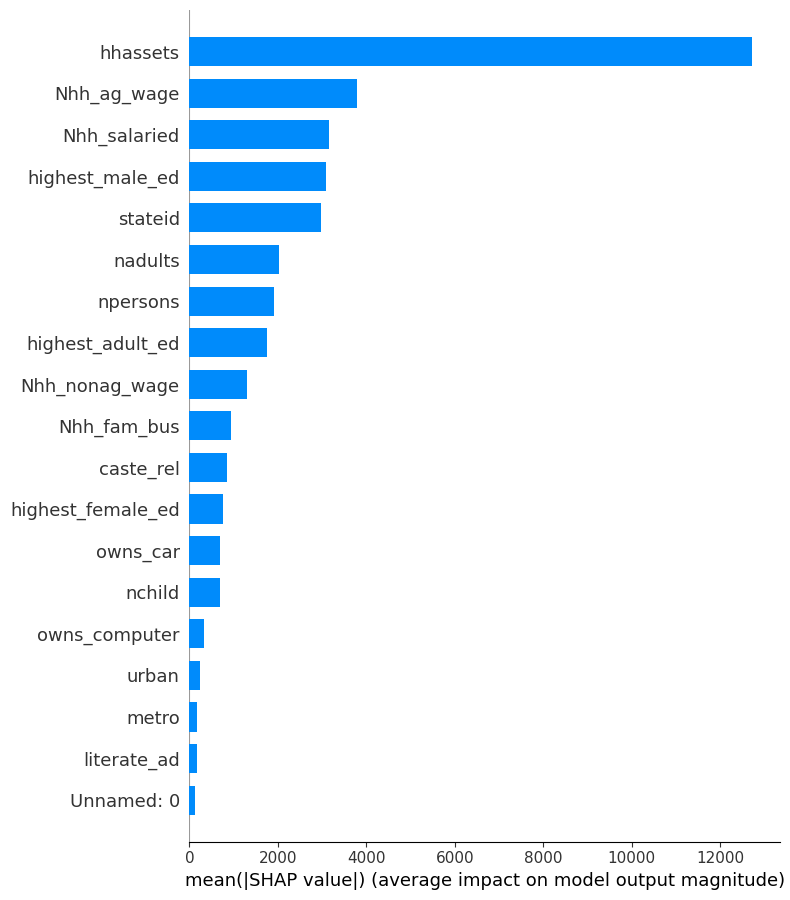

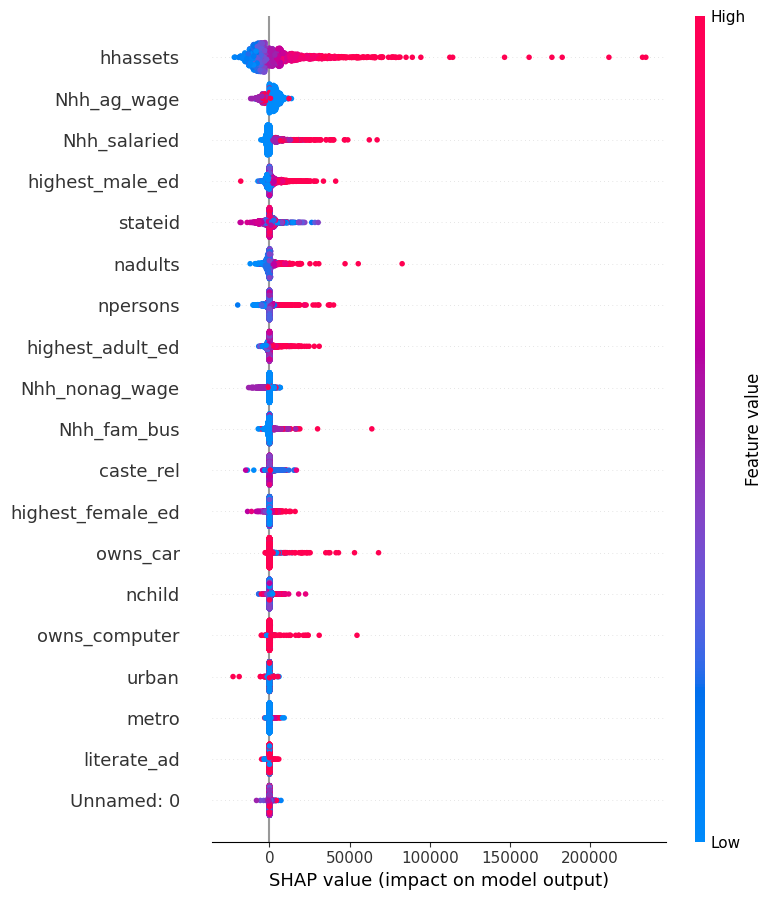

In [72]:
# SHAP - KernelExplainer
# 1. Helper to stack your dict inputs into [N, D]
def dict_to_tensor(X_dict):
    return torch.stack([X_dict[col] for col in X_dict], dim=1)

# 2. Build full tensors
X_train_tensor = dict_to_tensor(X_train)    # [N_train, D]
X_test_tensor  = dict_to_tensor(X_test)     # [N_test,  D]

# 3. Move to CPU & raw NumPy
background_full = X_train_tensor[:200].cpu().numpy()
test_array_full = X_test_tensor.cpu().numpy()

# 4. Summarize background with k-means for speed
K_bg = 30
background = shap.kmeans(background_full, K_bg).data

# 5. Subsample 10% of test set to explain
pct = 0.2
N_test = test_array_full.shape[0]
K_test = max(1, int(N_test * pct))
idx_test = np.random.choice(N_test, K_test, replace=False)
test_array = test_array_full[idx_test]

# 6. Your predict function (unchanged)
def predict_fn(np_array: np.ndarray) -> np.ndarray:
    batch = torch.tensor(np_array, dtype=torch.long, device=device)
    x_dict = {
        name: batch[:, i]
        for i, name in enumerate(X_train.keys())
    }
    with torch.no_grad():
        preds = trained_model(x_dict)
    return preds.cpu().numpy()

# 7. Create the KernelExplainer on the small background
explainer = shap.KernelExplainer(predict_fn, background)

# 8. Compute SHAP values on the test subset with fewer samples
shap_values = explainer.shap_values(test_array, nsamples=100)

# 9. Feature names
feature_names = list(X_train.keys())

# 10. Global summary plot (bar + beeswarm)
shap.summary_plot(shap_values, test_array, feature_names=feature_names, plot_type="bar")
shap.summary_plot(shap_values, test_array, feature_names=feature_names)

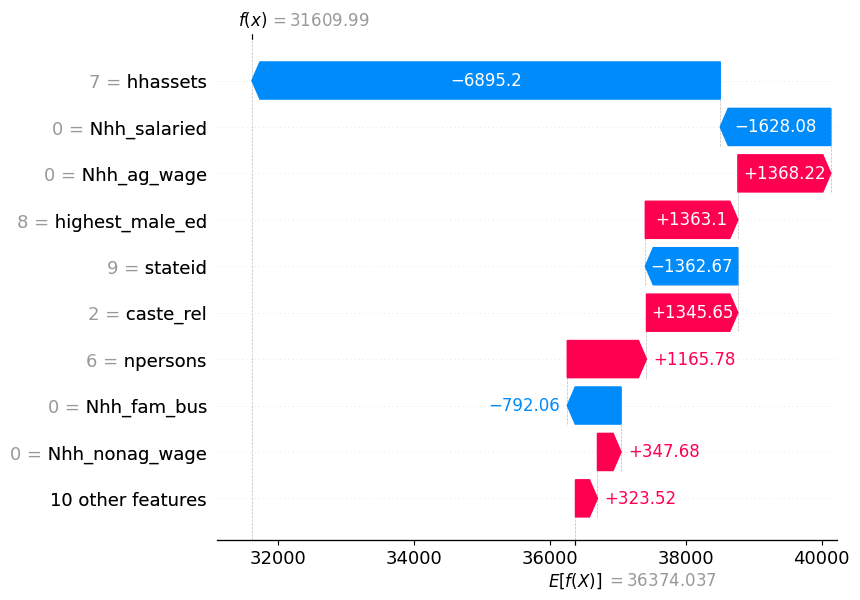

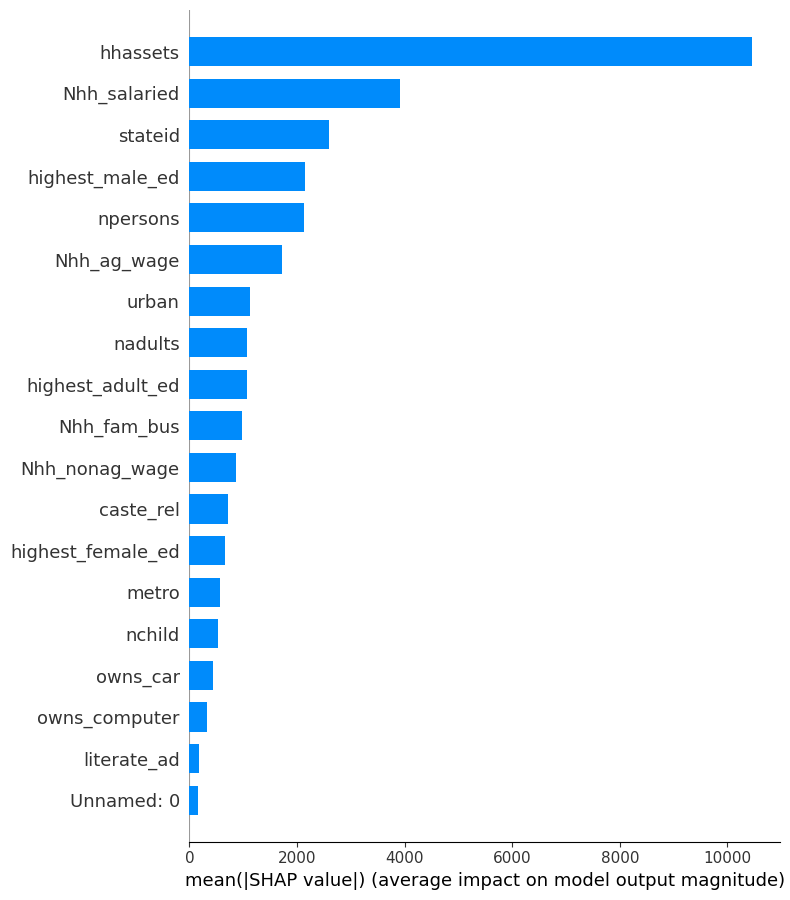

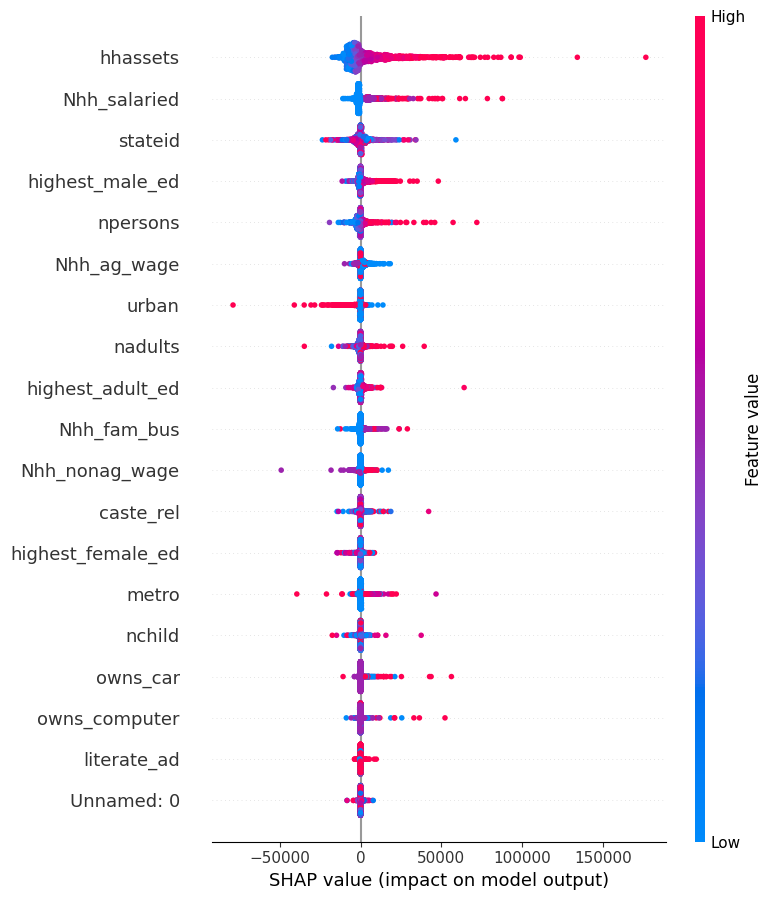

ValueError: Could not find feature named: age

In [67]:
# Local explanation for first test instance
shap.initjs()

# 2) Prepare a single-row DataFrame (or just use the NumPy row + feature_names)
instance_idx = 8
row_array = test_array[instance_idx]                       # shape (D,)
row_df    = pd.DataFrame([row_array], columns=feature_names)

# 3) Draw the force plot
shap.force_plot(
    explainer.expected_value,    # scalar or length-1 list
    shap_values[instance_idx],    # shape (D,)
    row_df                        # DataFrame with 1 row
)

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[instance_idx],
        base_values=explainer.expected_value,
        data=test_array[instance_idx],
        feature_names=feature_names
    )
)

shap.summary_plot(
    shap_values,
    test_array,
    feature_names=feature_names,
    plot_type="bar"
)

shap.summary_plot(
    shap_values,
    test_array,
    feature_names=feature_names
)

shap.dependence_plot(
    "age",             # feature name
    shap_values,
    test_array,
    feature_names=feature_names
)

shap.dependence_plot(
    "age",
    shap_values,
    test_array,
    feature_names=feature_names,
    interaction_index="years_of_education"
)

# mean absolute SHAP per feature
mean_abs = np.abs(shap_values).mean(axis=0)

feat_imp = pd.Series(
    mean_abs,
    index=feature_names
).sort_values(ascending=False)

print(feat_imp)